# Check distribution of likelihood ratio against Wilk's theorem

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import norm, chi2

## Settings

In [57]:
n_samples_per_measurement = 10

## Data

In [58]:
filenames = [
    "carl_fix",
    #"alice_fix",
    "alices_fix",
    #"carl_mass",
    #"alice_mass",
    "alices_mass",
    #"carl_align",
    #"alice_align",
    #"alices_align",
    #"carl_full",
    #"alice_full",
    "alices_full",
    #"carl_full_aux",
    #"alice_full_aux",
    #"alices_full_aux",
]
labels = [
    "CARL (fix)",
    #"ALICE (fix)",
    "ALICES (fix)",
    #"CARL (mass)",
    #"ALICE (mass)",
    "ALICES (mass)",
    #"CARL (align)",
    #"ALICE (align)",
    #"ALICES (align)",
    #"CARL (full)",
    #"ALICE (full)",
    "ALICES (full)",
    #"CARL (full-aux)",
    #"ALICE (full-aux)",
    #"ALICES (full-aux)",
]


nmethods = len(filenames)


In [59]:
llrs = []
for filename in filenames:
    llrs.append(np.load("../data/results/llr_{}_grid.npy".format(filename)))
llrs = np.array(llrs)
llrs.shape

(4, 625, 100000)

In [60]:
llrs = llrs.reshape(llrs.shape[0], llrs.shape[1], -1, n_samples_per_measurement)
llrs = np.sum(llrs, axis=3)
llrs.shape

(4, 625, 10000)

## Calculate likelihood ratio wrt best fit

In [61]:
resolution = 25

f_sub_1d = np.linspace(0.001, 0.200, resolution)
beta_1d = np.linspace(-2.5, -1.5, resolution)

theta0, theta1 = np.meshgrid(f_sub_1d, beta_1d)
theta_grid = np.vstack((theta0.flatten(), theta1.flatten())).T

bin_size = f_sub_1d[1] - f_sub_1d[0]
alpha_edges = np.linspace(f_sub_1d[0] - bin_size/2, f_sub_1d[-1] + bin_size/2, resolution + 1)
bin_size = beta_1d[1] - beta_1d[0]
beta_edges = np.linspace(beta_1d[0] - bin_size/2, beta_1d[-1] + bin_size/2, resolution + 1)

In [62]:
idx_mle = np.argmax(llrs, axis=1)
theta_mle = theta_grid[idx_mle]

In [63]:
for i in range(nmethods):
    bincount = np.bincount(idx_mle[0])
    idx_mle_max = np.argmax(bincount)
    n_mle_max = np.max(bincount)
    print(idx_mle_max, labels[i], theta_grid[idx_mle_max], n_mle_max / len(idx_mle[0]))

356 CARL (fix) [ 0.05075    -1.91666667] 0.1838
356 ALICES (fix) [ 0.05075    -1.91666667] 0.1838
356 ALICES (mass) [ 0.05075    -1.91666667] 0.1838
356 ALICES (full) [ 0.05075    -1.91666667] 0.1838


In [64]:
idx_true = 356
print(theta_grid[idx_true])
llr_true = llrs[:, idx_true, :]
llr_mle = np.max(llrs, axis=1)
print(llr_true.shape, llr_mle.shape)

[ 0.05075    -1.91666667]
(4, 10000) (4, 10000)


In [65]:
q = -2. * (llr_true - llr_mle)

In [66]:
llrs[0]

array([[-48.499123  , -49.58462   , -47.376827  , ..., -37.953125  ,
        -39.021725  , -45.70668   ],
       [-16.019672  , -21.380796  , -19.447832  , ...,  -7.5627217 ,
         -8.794922  , -16.687874  ],
       [  8.34025   ,  -1.7860961 ,  -0.6324878 , ...,  10.980682  ,
         11.870411  ,   3.4907699 ],
       ...,
       [  1.9547098 ,   1.3824787 ,   1.4626982 , ...,   4.530491  ,
         -1.676723  ,   6.176327  ],
       [  1.6491711 ,   0.9674056 ,   1.2611344 , ...,   3.4214594 ,
         -2.4833446 ,   6.140919  ],
       [  0.96220326,   0.13088083,   0.6368115 , ...,   2.421484  ,
         -2.9962277 ,   5.290626  ]], dtype=float32)

## Plot test statistic histo

In [67]:
qmin = 0.
qmax = 10.
qbins = 50


In [68]:
wilks = chi2.rvs(size=100000, df=2)

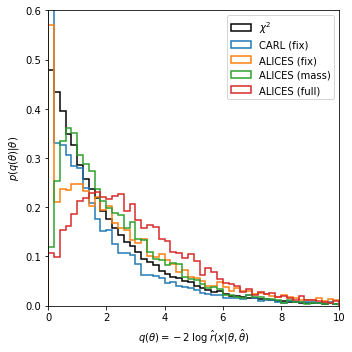

In [69]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

plt.hist(
    wilks, range=(qmin, qmax), bins=qbins,
    histtype="step", density=True,
    lw=1.5, color="black",
    label=r"$\chi^2$"
)
for i in range(nmethods):
    plt.hist(
        q[i], range=(qmin, qmax), bins=qbins,
        histtype="step", density=True,
        lw=1.5, color="C{}".format(i),
        label=labels[i]
    )
    
plt.legend()
    
#ax.set_yscale("log")
plt.xlim(qmin, qmax)
plt.ylim(0., .6)

plt.xlabel(r"$q(\theta) = -2\; \log \; \hat{r}(x|\theta, \hat{\theta})$")
plt.ylabel(r"$p(q(\theta) | \theta)$")
    
plt.tight_layout()
plt.savefig("../figures/chi_squared.pdf")

## Plot MLE

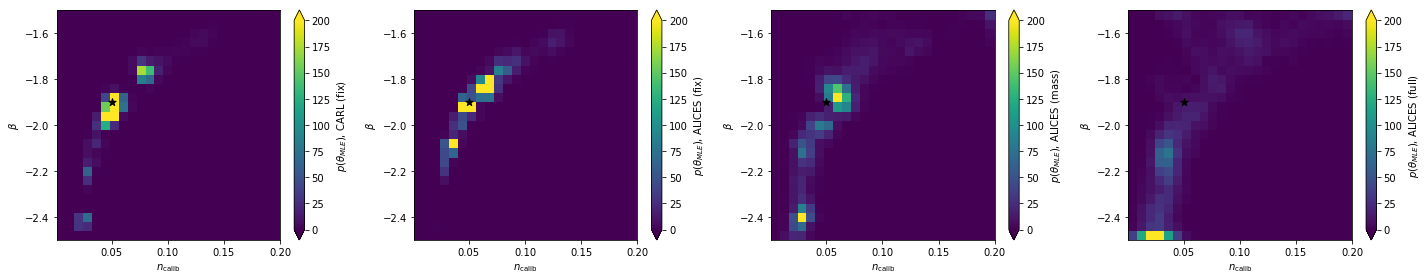

In [70]:
fig = plt.figure(figsize=(nmethods * 5, 4.))

for i in range(nmethods):
    ax = plt.subplot(1, nmethods, i+1)
    
    cm = plt.hist2d(
        theta_mle[i,:,0], theta_mle[i,:,1],
        bins=[25, 25],
        range=[[0.001,0.2], [-2.5,-1.5]],
        normed=True,
        norm=matplotlib.colors.Normalize(0., 200.),
        cmap="viridis"
    )[3]
    cbar = fig.colorbar(cm, ax=ax, extend='both', )
    cbar.set_label(r'$p(\theta_{MLE})$' + ', {}'.format(labels[i]))
    plt.scatter(0.05, -1.9, s=60., color='black', marker='*')

    plt.xlabel(r'$n_{\mathrm{calib}}$')
    plt.ylabel(r'$\beta$')
    
plt.tight_layout()
plt.savefig("../figures/mle_distribution.pdf")